# Proyecto de Clasificaci√≥n de Basura utilizando Deep Learning

**Nombre del autor**: Johnny Arica Prado

**Fecha**: 30/08/2025

## Objetivo del Proyecto

El objetivo de este proyecto es comparar el rendimiento de diferentes modelos preentrenados (MobileNetV3Small, EfficientNetB0, ResNet50) en la tarea de clasificaci√≥n de basura. Usaremos un conjunto de datos proporcionado por Roboflow que contiene im√°genes de diferentes tipos de basura (cart√≥n, vidrio, pl√°stico, metal, etc.). Evaluaremos el rendimiento de cada modelo utilizando m√©tricas como **accuracy**, **f1_macro**, **precision_macro**, **recall_macro** y **roc_auc_macro**.


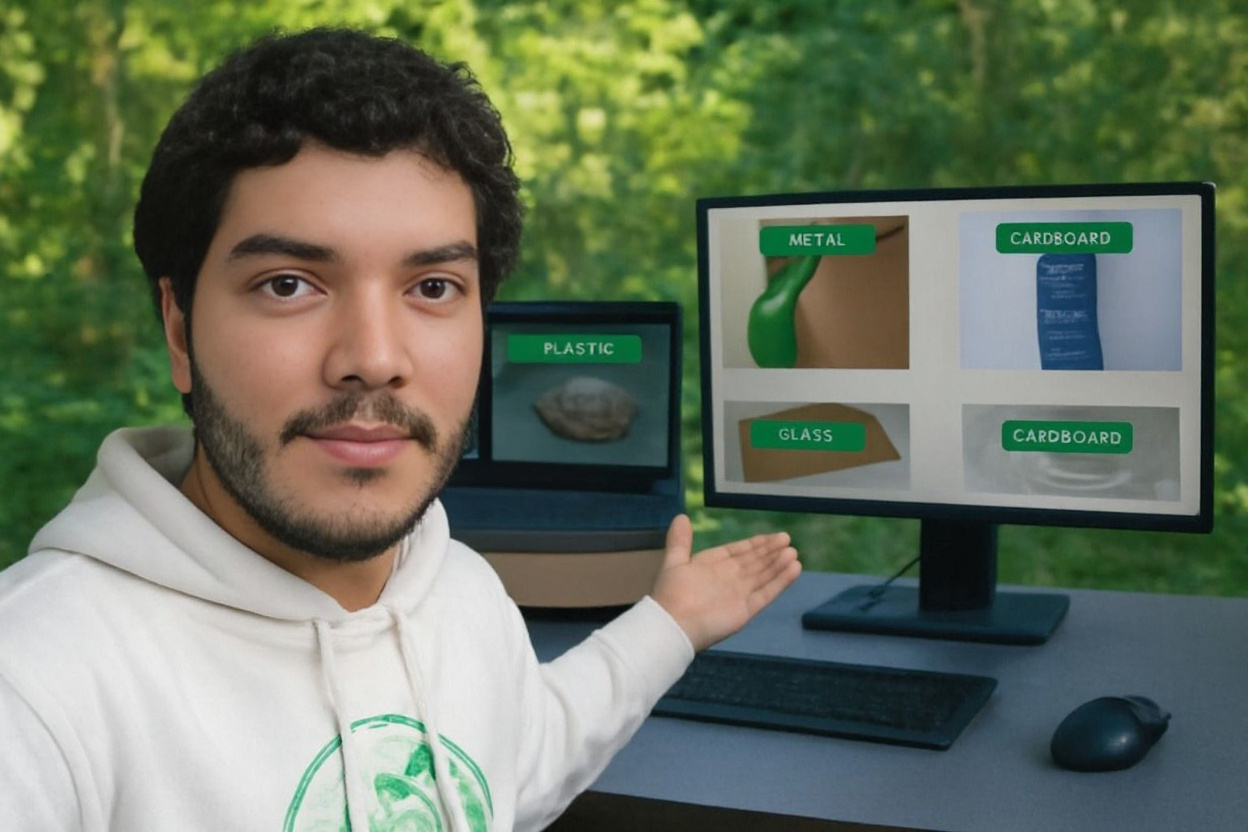

# **1. Setup (instalaciones pip, imports, selecci√≥n de GPU)**

En esta secci√≥n, configuramos el entorno de trabajo. Esto incluye la verificaci√≥n de la disponibilidad de la **GPU** en Google Colab, la instalaci√≥n de las librer√≠as necesarias (como TensorFlow y Keras) y la organizaci√≥n de las rutas de trabajo dentro de **Google Drive**.

### Pasos:
1. Instalamos las versiones correctas de las librer√≠as necesarias.
2. Montamos **Google Drive** para acceder a los datos y modelos.
3. Definimos las rutas de las carpetas donde guardaremos los **resultados** y los **modelos entrenados**.

In [ ]:
# === 1. Setup (instalaciones, imports, selecci√≥n de GPU) ===

# Verificar GPU (opcional, solo muestra si Colab te dio GPU Tesla T4 o similar)
!nvidia-smi || echo "‚ö†Ô∏è No se detecta GPU, revisa Entorno de ejecuci√≥n > Cambiar tipo > GPU"

# ---- Limpiar instalaciones previas que causan conflictos ----
!pip uninstall -y tensorflow keras tf-keras tensorflow-text tensorflow-decision-forests

# ---- Instalar versiones compatibles con Colab 2025 (CUDA 12.4) ----
!pip install -q tensorflow==2.19.1 keras==3.5.0 scikit-learn==1.5.2 matplotlib==3.9.2 pandas==2.2.3

# ---- Montar Google Drive ----
from google.colab import drive
drive.mount('/content/drive')

# ---- Definir rutas base del proyecto ----
import os
PROJ = "DL_Proyecto_AricaJohnny_Clasificacion"  # usa exactamente tu carpeta en Drive
BASE = f"/content/drive/MyDrive/{PROJ}"
DATA_DIR = os.path.join(BASE, "data")
SPLIT_DIR = os.path.join(DATA_DIR, "split")
RESULTS = os.path.join(BASE, "results")
MODELS = os.path.join(BASE, "models")

for d in [DATA_DIR, SPLIT_DIR, RESULTS, MODELS]:
    os.makedirs(d, exist_ok=True)

# ---- Imports principales ----
import zipfile, glob, shutil, random
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.metrics import (
    classification_report, confusion_matrix,
    f1_score, precision_score, recall_score, roc_auc_score
)

print("‚úÖ Setup completo - TensorFlow:", tf.__version__)

Sun Aug 24 03:43:46 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   71C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# **2. Datos (carga, ruta/fuente, particiones)**

Para este proyecto, hemos utilizado un conjunto de datos de **clasificaci√≥n de basura** disponible en **Roboflow**. El conjunto de datos se encuentra en un archivo **ZIP** y contiene im√°genes divididas en tres particiones: **train** (entrenamiento), **valid** (validaci√≥n) y **test** (prueba).

En esta secci√≥n, vamos a descomprimir el archivo, contar cuantas imagenes hay en cada particion y de que tipo.


In [ ]:
# === 2. Datos (usar splits de Roboflow tal cual) ===

import os, glob, zipfile, pandas as pd

# Ruta del ZIP original
DATA_ZIP = os.path.join(DATA_DIR, "garbage_dataset.zip")  # cambia si tu archivo tiene otro nombre
EXTRACT_DIR = os.path.join(DATA_DIR, "roboflow_splits")

# --- Descomprimir una sola vez ---
if os.path.exists(DATA_ZIP) and not os.path.exists(EXTRACT_DIR):
    with zipfile.ZipFile(DATA_ZIP, "r") as zf:
        zf.extractall(EXTRACT_DIR)

# Definir rutas directas a los splits de Roboflow
TRAIN_DIR = os.path.join(EXTRACT_DIR, "train")
VAL_DIR   = os.path.join(EXTRACT_DIR, "valid")
TEST_DIR  = os.path.join(EXTRACT_DIR, "test")

print("üìÇ Usando dataset Roboflow directamente en:")
print("TRAIN_DIR:", TRAIN_DIR)
print("VAL_DIR:", VAL_DIR)
print("TEST_DIR:", TEST_DIR)

# --- Funci√≥n para contar im√°genes ---
def count_images(path):
    report = []
    for cls in sorted(os.listdir(path)):
        cdir = os.path.join(path, cls)
        if os.path.isdir(cdir):
            report.append({"class": cls, "images": len(glob.glob(os.path.join(cdir, '*')))})
    return pd.DataFrame(report)

print("\nConteos TRAIN:\n", count_images(TRAIN_DIR))
print("\nConteos VAL:\n", count_images(VAL_DIR))
print("\nConteos TEST:\n", count_images(TEST_DIR))


üìÇ Usando dataset Roboflow directamente en:
TRAIN_DIR: /content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/data/roboflow_splits/train
VAL_DIR: /content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/data/roboflow_splits/valid
TEST_DIR: /content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/data/roboflow_splits/test

Conteos TRAIN:
        class  images
0  cardboard     520
1      glass     617
2      metal     505
3      paper     719
4    plastic     559
5      trash     172

Conteos VAL:
        class  images
0  cardboard      65
1      glass      94
2      metal      90
3      paper     128
4    plastic     102
5      trash      25

Conteos TEST:
        class  images
0  cardboard      40
1      glass      55
2      metal      33
3      paper      53
4    plastic      57
5      trash      14


# **3. Preprocesamiento**

Cargar las im√°genes en **tensores** con **TensorFlow** y aplicar **data augmentation** en las im√°genes de entrenamiento para mejorar el rendimiento del modelo. Adem√°s, las im√°genes ser√°n redimensionadas a **224x224 p√≠xeles** para adaptarse a los modelos preentrenados que vamos a usar.

El conjunto de datos contiene 6 clases: **cart√≥n, vidrio, pl√°stico, metal, papel y basura**.

In [ ]:
# === 3. Preprocesamiento ===

import tensorflow as tf
from tensorflow.keras import layers

IMG_SIZE = 224
BATCH = 32
seed = 42

# Cargar datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    label_mode="categorical",
    shuffle=True,
    seed=seed
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    label_mode="categorical",
    shuffle=False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH,
    label_mode="categorical",
    shuffle=False
)

# Nombres de clases
class_names = train_ds.class_names
num_classes = len(class_names)
print("‚úÖ Clases detectadas:", class_names, "| Total:", num_classes)

# Data augmentation (solo para entrenamiento)
data_augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

# Optimizar pipeline con prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(lambda x,y: (data_augment(x), y)).prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)
test_ds  = test_ds.prefetch(AUTOTUNE)


Found 3092 files belonging to 6 classes.
Found 504 files belonging to 6 classes.
Found 252 files belonging to 6 classes.
‚úÖ Clases detectadas: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash'] | Total: 6


# **4. Entrenamiento A/B/C**

Para este proyecto, entrenamos tres modelos preentrenados: **MobileNetV3Small**, **EfficientNetB0** y **ResNet50**. Estos modelos han sido previamente entrenados en el conjunto de datos **ImageNet**, lo que les permite extraer caracter√≠sticas generales de las im√°genes.

Usamos **Transfer Learning** con **fine-tuning** para adaptar estos modelos a nuestro problema de clasificaci√≥n de basura. Entrenamos cada modelo durante **20 √©pocas** utilizando el optimizador **Adam** y empleamos los callbacks de **EarlyStopping** y **ReduceLROnPlateau** para evitar el sobreajuste y optimizar el proceso de aprendizaje.

### Pasos:
1. Cargar los modelos preentrenados.
2. A√±adir una capa de salida personalizada para la clasificaci√≥n de 6 clases.
3. Entrenar los modelos en el conjunto de entrenamiento y validaci√≥n.

In [ ]:
# === 4. Entrenamiento A/B/C ===

from tensorflow.keras.applications import (
    MobileNetV3Small, EfficientNetB0, ResNet50
)
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as pre_mnv3
from tensorflow.keras.applications.efficientnet import preprocess_input as pre_eff
from tensorflow.keras.applications.resnet import preprocess_input as pre_res
from tensorflow.keras import layers, Model
import tensorflow as tf

IMG_SIZE = 224
BATCH = 32
seed = 42

# Funci√≥n gen√©rica para construir clasificador
def build_classifier(base_model, preprocess, img_size=224, num_classes=6, train_base=False):
    inputs = tf.keras.Input(shape=(img_size, img_size, 3))
    x = preprocess(inputs)
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = Model(inputs, outputs)

    base_model.trainable = train_base  # False: solo cabeza, True: fine-tune
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

# Instancias de cada variante
baseA = MobileNetV3Small(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights="imagenet")
modelA = build_classifier(baseA, pre_mnv3, IMG_SIZE, num_classes)

baseB = EfficientNetB0(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights="imagenet")
modelB = build_classifier(baseB, pre_eff, IMG_SIZE, num_classes)

baseC = ResNet50(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights="imagenet")
modelC = build_classifier(baseC, pre_res, IMG_SIZE, num_classes)

# Callbacks
cb = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True, monitor="val_accuracy"),
    tf.keras.callbacks.ReduceLROnPlateau(patience=2, factor=0.2)
]

# Entrenamientos
histA = modelA.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=cb)
histB = modelB.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=cb)
histC = modelC.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=cb)

# Guardar modelos en formato .keras (nuevo formato)
modelA.save(os.path.join(MODELS, "A_MobileNetV3Small.keras"))
modelB.save(os.path.join(MODELS, "B_EfficientNetB0.keras"))
modelC.save(os.path.join(MODELS, "C_ResNet50.keras"))


4334752/4334752 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 0us/step
16705208/16705208 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 0us/step
94765736/94765736 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 0us/step
Epoch 1/20
97/97 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 746s 7s/step - accuracy: 0.4157 - loss: 1.5497 - val_accuracy: 0.7202 - val_loss: 0.7755 - learning_rate: 0.0010
Epoch 2/20
97/97 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 47s 485ms/step - accuracy: 0.7198 - loss: 0.7865 - val_accuracy: 0.7718 - val_loss: 0.6475 - learning_rate: 0.0010
Epoch 3/20
97/97 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 47s 483ms/step - accuracy: 0.7731 - loss: 0.6385 - val_accuracy: 0.7937 - val_loss: 0.5949 - learning_rate: 0.0010
Epoch 4/20
97/97 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 47s 480ms/step - accuracy: 0.8012 - loss: 0.5653 - val_accuracy: 0.8016 - 

# **5. Evaluaci√≥n (test) ‚Üí gr√°ficos por m√©trica y modelo**

Una vez entrenados los modelos, evaluamos su rendimiento en el conjunto de prueba. Calculamos diversas m√©tricas como **accuracy**, **f1_macro**, **precision_macro**, **recall_macro** y **roc_auc_macro**, que nos permiten analizar la capacidad del modelo para clasificar correctamente las im√°genes de cada clase.

Adem√°s, generamos la **matriz de confusi√≥n** para visualizar el rendimiento del modelo en cada clase.

### Pasos:
1. Cargar los modelos entrenados.
2. Evaluar los modelos en el conjunto de prueba.
3. Calcular las m√©tricas de rendimiento.
4. Generar la matriz de confusi√≥n.


Buscando en: /content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/models/A_MobileNetV3Small.keras
Buscando en: /content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/models/B_EfficientNetB0.keras
Buscando en: /content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/models/C_ResNet50.keras
Modelos detectados:
 - MobileNetV3Small: /content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/models/A_MobileNetV3Small.keras
 - EfficientNetB0: /content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/models/B_EfficientNetB0.keras
 - ResNet50: /content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/models/C_ResNet50.keras


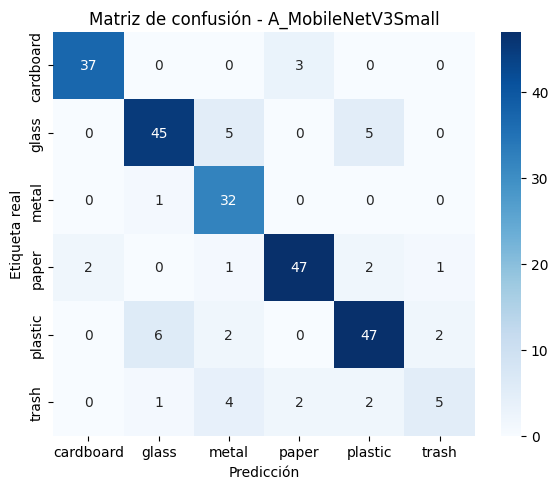

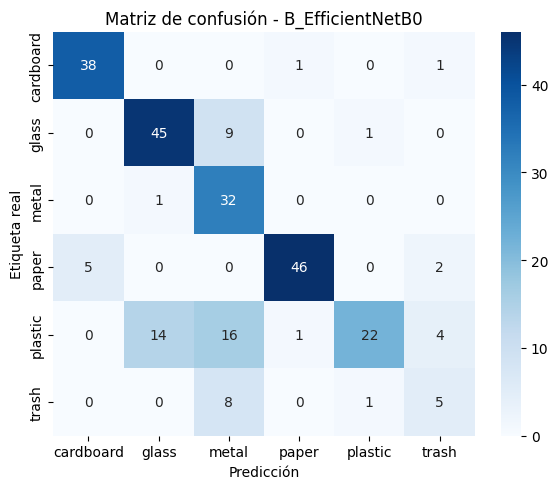

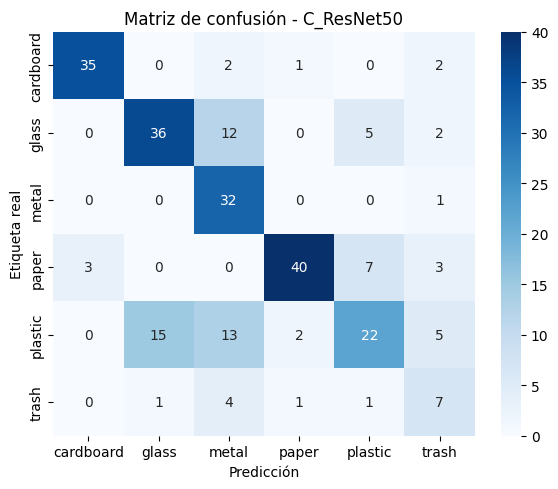

modelo  accuracy_test  f1_macro_test  precision_macro_test  \
0  A_MobileNetV3Small       0.845238       0.797142              0.815530   
1    B_EfficientNetB0       0.746032       0.698341              0.736283   
2          C_ResNet50       0.682540       0.658628              0.668160   

   recall_macro_test  roc_auc_macro_test  
0           0.796896            0.962869  
1           0.724819            0.946678  
2           0.689987            0.929025

In [ ]:
# === 5. Evaluaci√≥n (test) ===

import numpy as np
import seaborn as sns
import os
import glob
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt

# ---------- 5.1: detectar modelos entrenados ----------
def find_model_file(model_dir):
    # Asegurarse de que busca correctamente en la carpeta models
    for ext in [".keras"]:
        # Cambi√© la ruta BASE, usa la correcta de tu Google Drive
        search_path = os.path.join(BASE, "models", f"{model_dir}{ext}")
        print(f"Buscando en: {search_path}")  # Imprimir las rutas que se est√°n buscando
        files = glob.glob(search_path)
        if files:
            return files[0]
    return None

# --- Importar funciones de preprocesamiento de cada modelo ---
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input as pre_mnv3
from tensorflow.keras.applications.efficientnet import preprocess_input as pre_eff
from tensorflow.keras.applications.resnet import preprocess_input as pre_res

# --- Diccionario con informaci√≥n sobre los modelos ---
MODEL_REGISTRY = {
    "MobileNetV3Small": {
        "path": find_model_file("A_MobileNetV3Small"),
        "pre": pre_mnv3,
        "size": (224, 224)
    },
    "EfficientNetB0": {
        "path": find_model_file("B_EfficientNetB0"),
        "pre": pre_eff,
        "size": (224, 224)
    },
    "ResNet50": {
        "path": find_model_file("C_ResNet50"),
        "pre": pre_res,
        "size": (224, 224)
    }
}

# --- Verificaci√≥n de los modelos detectados ---
print("Modelos detectados:")
for model_name, model_info in MODEL_REGISTRY.items():
    if model_info['path']:
        print(f" - {model_name}: {model_info['path']}")
    else:
        print(f" - {model_name}: No encontrado")

# --- Cargar los modelos detectados ---
modelA = load_model(MODEL_REGISTRY["MobileNetV3Small"]['path'])
modelB = load_model(MODEL_REGISTRY["EfficientNetB0"]['path'])
modelC = load_model(MODEL_REGISTRY["ResNet50"]['path'])

# --- Funci√≥n de evaluaci√≥n con preprocesamiento expl√≠cito ---
def eval_model(model, name):
    y_prob, y_true = [], []
    for x, y in test_ds:
        # Asegurarse de que las im√°genes sean preprocesadas correctamente
        if name == "A_MobileNetV3Small":
            x = pre_mnv3(x)  # Preprocesamiento espec√≠fico para MobileNetV3
        elif name == "B_EfficientNetB0":
            x = pre_eff(x)  # Preprocesamiento espec√≠fico para EfficientNetB0
        elif name == "C_ResNet50":
            x = pre_res(x)  # Preprocesamiento espec√≠fico para ResNet50

        p = model.predict(x, verbose=0)
        y_prob.append(p)
        y_true.append(y.numpy())

    y_prob = np.vstack(y_prob)
    y_true = np.vstack(y_true)

    y_pred = y_prob.argmax(axis=1)
    y_true_lab = y_true.argmax(axis=1)

    # --- M√©tricas ---
    acc = (y_pred == y_true_lab).mean()
    f1m = f1_score(y_true_lab, y_pred, average="macro")
    prm = precision_score(y_true_lab, y_pred, average="macro")
    rcm = recall_score(y_true_lab, y_pred, average="macro")
    aucm = roc_auc_score(y_true, y_prob, average="macro", multi_class="ovr")

    # --- Matriz de confusi√≥n ---
    cm = confusion_matrix(y_true_lab, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Matriz de confusi√≥n - {name}")
    plt.ylabel("Etiqueta real")
    plt.xlabel("Predicci√≥n")
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS, f"confusion_{name}.png"), dpi=150)
    plt.show()

    return {
        "modelo": name,
        "accuracy_test": acc,
        "f1_macro_test": f1m,
        "precision_macro_test": prm,
        "recall_macro_test": rcm,
        "roc_auc_macro_test": aucm
    }

# --- Evaluar los tres modelos ---
resA = eval_model(modelA, "A_MobileNetV3Small")
resB = eval_model(modelB, "B_EfficientNetB0")
resC = eval_model(modelC, "C_ResNet50")

# --- Guardar los resultados en un DataFrame ---
df = pd.DataFrame([resA, resB, resC])
df.to_csv(os.path.join(RESULTS, "metricas_test.csv"), index=False)

# Mostrar el DataFrame
df


## Gr√°ficos Comparativos de M√©tricas

Para facilitar la comparaci√≥n entre los modelos, generamos gr√°ficos de barras para cada una de las m√©tricas evaluadas (accuracy, f1_macro, precision_macro, etc.). Esto nos permite ver de manera visual qu√© modelo tiene el mejor rendimiento en cada m√©trica.

A continuaci√≥n, se presentan los gr√°ficos comparativos para cada una de las m√©tricas seleccionadas.

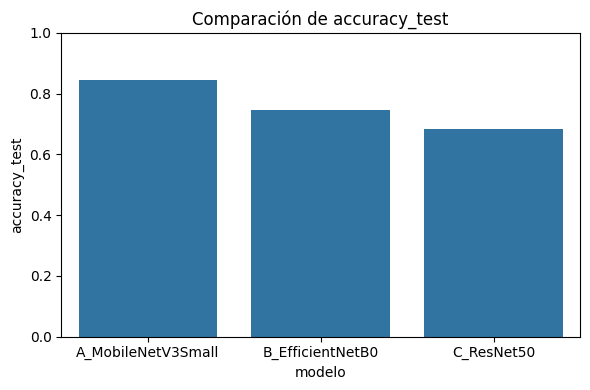

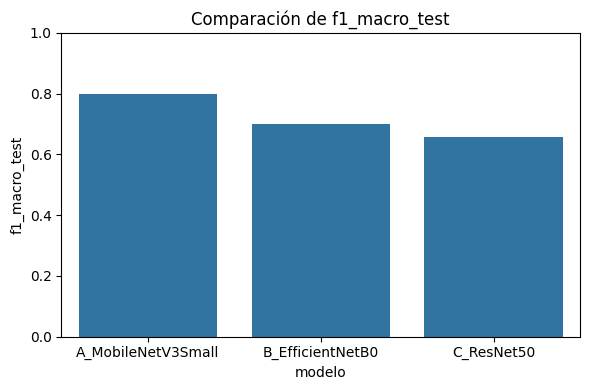

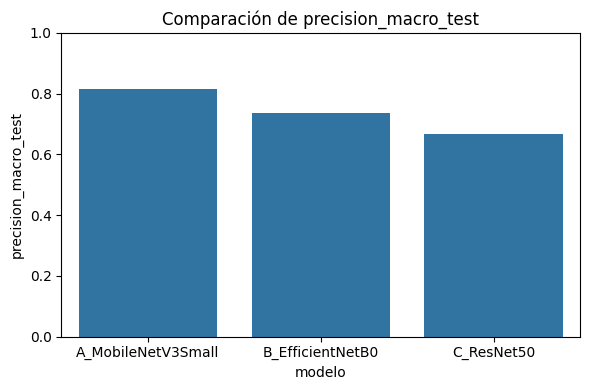

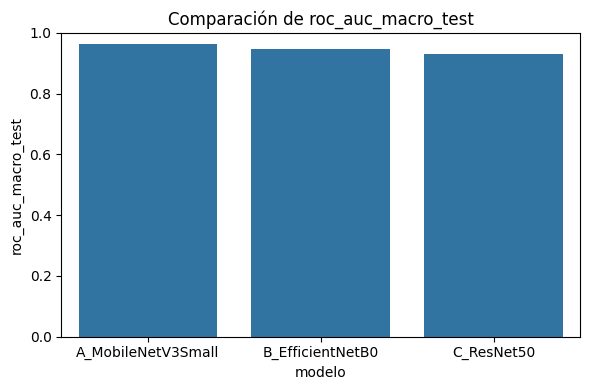

In [ ]:
# === Gr√°ficos comparativos de m√©tricas ===

# Lista de m√©tricas a comparar
metrics = ["accuracy_test", "f1_macro_test", "precision_macro_test", "recall_macro_test", "roc_auc_macro_test"]

# Generar gr√°ficos para cada m√©trica
for m in metrics:
    plt.figure(figsize=(6,4))  # Tama√±o del gr√°fico
    sns.barplot(x="modelo", y=m, data=df)  # Gr√°fico de barras
    plt.title(f"Comparaci√≥n de {m}")  # T√≠tulo del gr√°fico
    plt.ylim(0, 1)  # Rango de las m√©tricas (de 0 a 1)
    plt.tight_layout()  # Ajustar el dise√±o para evitar sobreposiciones
    plt.savefig(os.path.join(RESULTS, f"metric_{m}.png"), dpi=150)  # Guardar la imagen
    plt.show()  # Mostrar el gr√°fico


## Curvas de Entrenamiento (Loss y Accuracy)

Las curvas de entrenamiento muestran la evoluci√≥n de las m√©tricas de **accuracy** y **loss** a lo largo de las **√©pocas**. Estas curvas nos permiten analizar c√≥mo el modelo fue mejorando durante el entrenamiento y si hubo sobreajuste o subajuste.

A continuaci√≥n, se muestran las curvas de **accuracy** y **loss** para cada modelo entrenado.

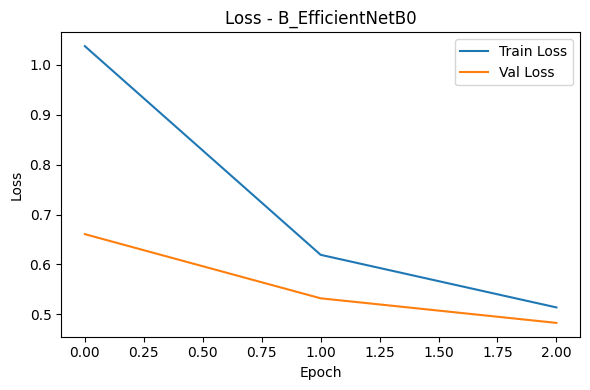

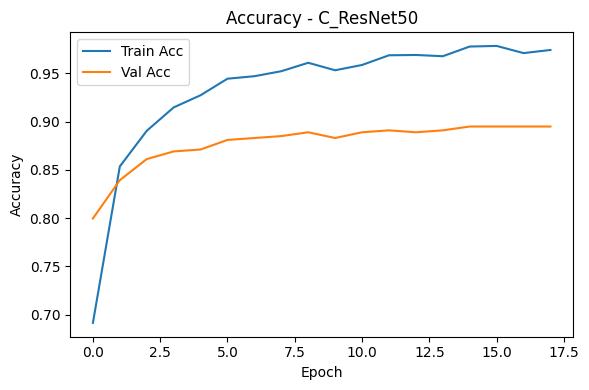

In [ ]:
# === Curvas de entrenamiento (loss y accuracy) ===

def plot_history(hist, name):
    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(hist.history["accuracy"], label="Train Acc")
    plt.plot(hist.history["val_accuracy"], label="Val Acc")
    plt.title(f"Accuracy - {name}")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS, f"train_acc_{name}.png"), dpi=150)
    plt.show()

    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(hist.history["loss"], label="Train Loss")
    plt.plot(hist.history["val_loss"], label="Val Loss")
    plt.title(f"Loss - {name}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(RESULTS, f"train_loss_{name}.png"), dpi=150)
    plt.show()

# Graficar para los 3 modelos
plot_history(histA, "A_MobileNetV3Small")
plot_history(histB, "B_EfficientNetB0")
plot_history(histC, "C_ResNet50")


# **6. Inferencia de ejemplo (capturas obligatorias)**

En esta secci√≥n, realizamos inferencias utilizando im√°genes de prueba. Para cada imagen, mostramos la **etiqueta real**, la **predicci√≥n** del modelo y la **probabilidad** asociada a la predicci√≥n. Esto nos ayuda a visualizar c√≥mo el modelo realiza la clasificaci√≥n en ejemplos concretos.

A continuaci√≥n, se presentan las inferencias de ejemplo para cada modelo.


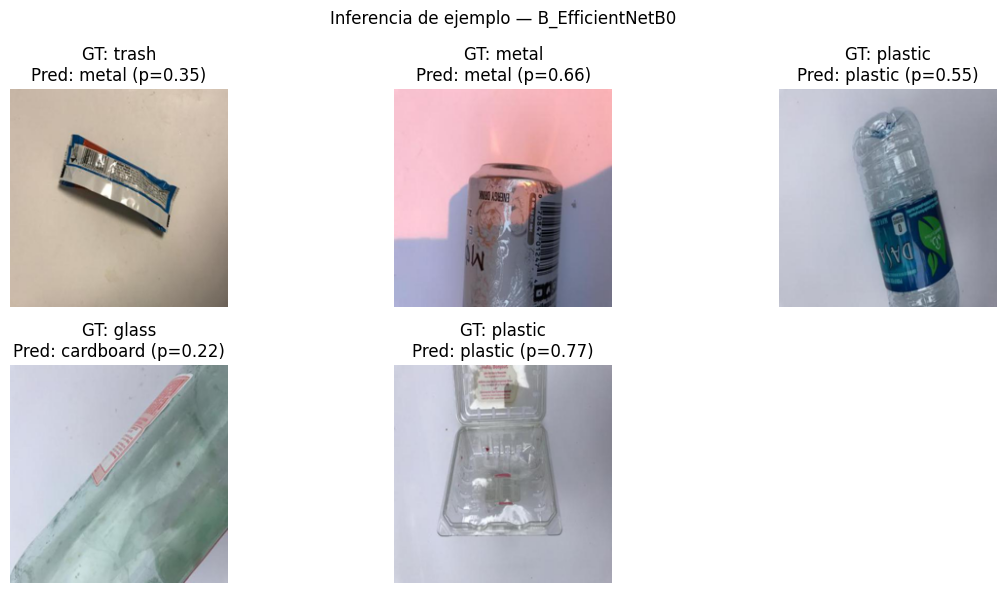

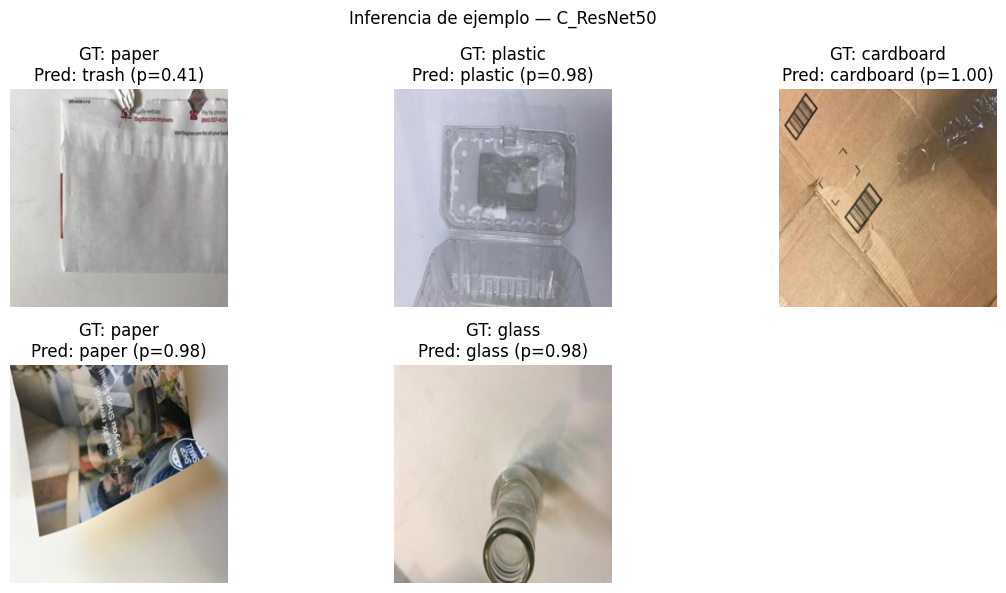

In [ ]:
# === 6. Inferencia de ejemplo (obligatoria) ===

import matplotlib.pyplot as plt
import numpy as np
import os
import random
import glob
import PIL.Image as Image
from tensorflow.keras.models import load_model

# Funci√≥n para muestrear im√°genes del directorio
def sample_images_from_dir(root, n=5):
    imgs = []
    for cls in class_names:
        imgs += glob.glob(os.path.join(root, cls, "*"))
    random.shuffle(imgs)
    return imgs[:n]

# Funci√≥n para hacer la predicci√≥n sobre una imagen
def predict_image(path, model, preprocess, img_size=224):
    img = Image.open(path).convert("RGB").resize((img_size,img_size))
    x = np.array(img)[None, ...].astype("float32")
    x = preprocess(x)  # Preprocesamiento de la imagen
    prob = model.predict(x, verbose=0)[0]
    idx = int(np.argmax(prob))
    return img, idx, prob

# Funci√≥n para generar paneles de inferencia
def make_inference_panel(model, preprocess, model_name, out_png):
    paths = sample_images_from_dir(TEST_DIR, n=5)  # Tomar 5 im√°genes aleatorias
    plt.figure(figsize=(12,6))
    for i, p in enumerate(paths, 1):
        img, idx, prob = predict_image(p, model, preprocess, IMG_SIZE)  # Preprocesamiento dentro del modelo
        true_cls = os.path.basename(os.path.dirname(p))
        pred_cls = class_names[idx]
        conf = float(prob[idx])
        ax = plt.subplot(2,3,i)
        ax.imshow(img)
        ax.axis("off")
        ax.set_title(f"GT: {true_cls}\nPred: {pred_cls} (p={conf:.2f})")
    plt.suptitle(f"Inferencia de ejemplo ‚Äî {model_name}")
    plt.tight_layout()
    plt.savefig(out_png, dpi=150)
    plt.show()

# --- Cargar los modelos guardados en formato .keras ---
modelA = load_model('/content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/models/A_MobileNetV3Small.keras')
modelB = load_model('/content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/models/B_EfficientNetB0.keras')
modelC = load_model('/content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/models/C_ResNet50.keras')

# --- Realizar inferencias y guardar los resultados en im√°genes ---
make_inference_panel(modelA, pre_mnv3, "A_MobileNetV3Small", os.path.join(RESULTS, "inferencias_A.png"))
make_inference_panel(modelB, pre_eff, "B_EfficientNetB0", os.path.join(RESULTS, "inferencias_B.png"))
make_inference_panel(modelC, pre_res, "C_ResNet50", os.path.join(RESULTS, "inferencias_C.png"))


# **7. Guardado de resultados (figuras/tablas en /results)**

Para mantener un registro de todos los artefactos generados durante el proyecto (gr√°ficos, tablas, modelos, etc.), hemos creado un archivo **`artefactos.json`** que lista todos los archivos guardados en la carpeta **`RESULTS`**. Esto incluye las **matrices de confusi√≥n**, los **gr√°ficos de m√©tricas** y los **modelos entrenados**.

Este archivo tambi√©n enumera los modelos entrenados guardados en formato **`.keras`**, listando las rutas para su acceso posterior.

In [ ]:
# === 7. Guardado y resumen de artefactos ===
import json, pathlib
artifacts = sorted([str(p) for p in pathlib.Path(RESULTS).glob("*")])
with open(os.path.join(RESULTS, "artefactos.json"), "w") as f:
    json.dump({"results": artifacts}, f, indent=2)

print("Guardados en /results:")
for a in artifacts: print(" -", a)

print("\nModelos en /models:")
for a in sorted([str(p) for p in pathlib.Path(MODELS).glob("*.keras")]):
    print(" -", a)

Guardados en /results:
 - /content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/results/artefactos.json
 - /content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/results/confusion_A_MobileNetV3Small.png
 - /content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/results/confusion_B_EfficientNetB0.png
 - /content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/results/confusion_C_ResNet50.png
 - /content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/results/inferencias_A.png
 - /content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/results/inferencias_B.png
 - /content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/results/inferencias_C.png
 - /content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/results/metric_accuracy_test.png
 - /content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/results/metric_f1_macro_test.png
 - /content/drive/MyDrive/DL_Proyecto_AricaJohnny_Clasificacion/results/metric_precision_macro_test.png
 - /content/driv